# scrapy终端与核心组件

## 一.scrapy shell

scrapy shell是一个交互式终端,可用于在不启动爬虫的情况下尝试及调试爬取代码.也可以用来测试XPath或CSS表达式,查看它们的工作方式以及爬取的网页中提取的数据

scrapy shell一般使用标准python终端,但是如果安装了IPython,scrapy shell将优先使用IPython

### 1.启动scrapy shell

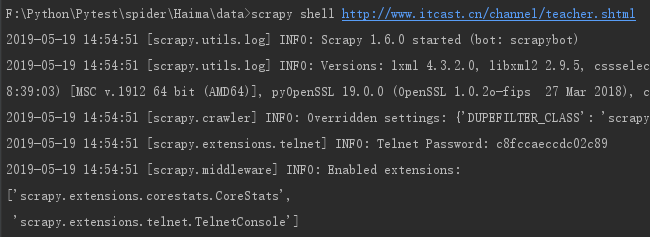

In [1]:
from IPython.display import Image
Image(filename="./data/11_1.png",width=500)

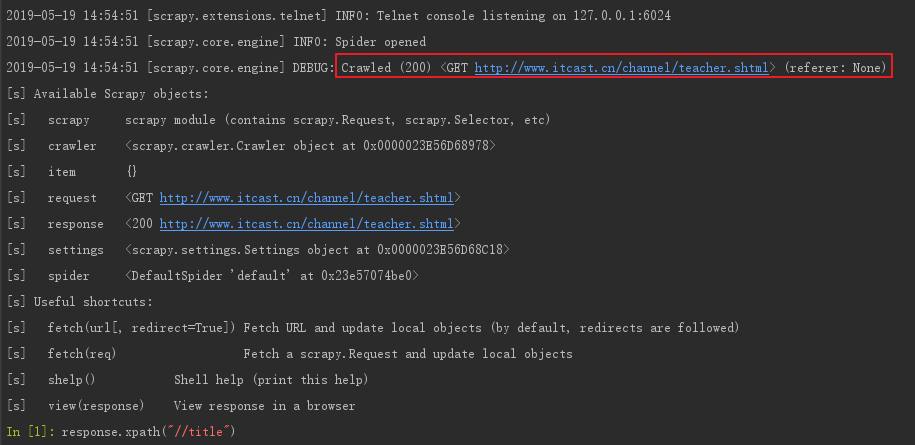

In [2]:
Image(filename="./data/11_2.png",width=500)

### 2.使用scrapy shell

scrapy shell可以看成一个在python终端基础上添加了扩充功能的python控制台程序,这些扩充包括若干功能函数和内置对象

<b>功能函数</b>

scrapy shell提供的功能函数主要包括以下3种：
1. shelp()：打印可用对象和快捷命令的帮助列表
2. fetch(request_or_url)：根据给定的请求request或URL获取一个新的response对象,并更新原有的相关对象
3. view(response)：使用本机的浏览器打开给定的response对象,该函数会在response的body中添加一个<base>标签,使得外部链接能正确显示

<b>内置对象</b>

使用scrapy shell下载指定页面时,会生成一些可用的内置对象,例如response对象和selector对象(针对Html和XML内容).这些对象包括：
1. crawler：当前Crawler对象
2. spider：处理URL的spider
3. request：最近获取到的页面的request对象.可以使用replace()修改该request,也可以使用fetch功能函数来获取新的request
4. response：包含最近获取到的页面的Response对象
5. sel：根据最近获取到的response构建的Selector对象
6. settings：当前的scrapy settings

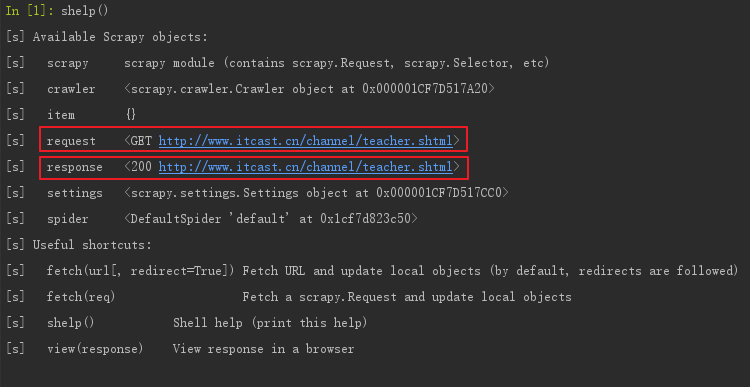

In [1]:
from IPython.display import Image
Image(filename="./data/11_3.png",width=500)

将request的请求方式更改为POST,然后调用fetch()函数获取新的response

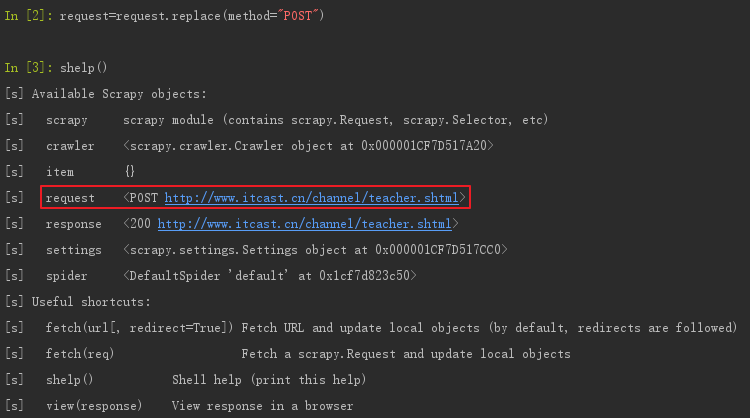

In [3]:
Image(filename="./data/11_4.png",width=500)

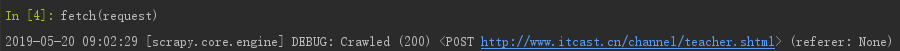

In [4]:
Image(filename="./data/11_5.png",width=500)

当scrapy shell载人页面后,将得到一个包含Response数据的本地response变量.在终端输入response.body可以看出终端输出response的包体,输入response.headers可以看到response的包头

输入response.selector时,将获取一个response初始化的类selector的对象(对HTML及XML内容),此时可以通过使用response.selector.xpath()或response.selector.css()来对response进行查询.另外scrapy还提供了一些快捷方式,例如response.xpath()或response.css()同样可以生效

### 3.scrapy选择器方法

与scrapy选择器相关的有4个常用的方法,具体如下：
1. xpath()：传入xpath表达式,返回该表达式对应的所有节点的selector对象列表
2. css()：传入css表达式,返回该表达式所对应的所有结点的selector list列表,语法同bs4
3. extract()：返回该选择器对象(或对象列表)对应的字符串列表
4. re()：根据传入的正则表达式对选择器对象(或对象列表)中的数据进行提取,返回Unicode字符串列表

其中,前两个方法返回的都是选择器列表,最常用的是xpath()方法;后两个方法则是返回选择器对象(或对象列表)的字符串内容

## 三.Item Pipeline--后期处理数据

当Item在spiders中被收集之后,会被传递到Item Pipeline(管道).用户可以在scrapy项目中定义多个管道,这些管道按定义的顺序依次处理Item

每个管道都是一个python类,在这个类中实现了一些操作Item的方法

### 1.自定义Item Pipeline

自定义Item Pipeline很简单,每个Item Pipeline组件都是一个独立的python类.该类中的`process_item()`方法必须实现,每个Item Pipeline组件都需要调用process_item()方法

`process_item()`方法必须返回一个Item(或任何继承类)对象,或者抛出DropItem异常,被丢弃的Item将不会被之后的Pipeline组件所处理.该方法的定义如下：

In [ ]:
process_item(self,item,spider)

从定义可知,`process_item()`方法有2个参数,分别是：
1. item：表示被爬取的Item对象
2. spider：表示爬取该Item的spider对象

In [ ]:
import something

class SomethingPipeline(object):
    def __init__(self):
        # 可选实现
    def process_item(self,item,spider):
        # item(Item对象)--被爬取的Item
        # spider(Spider对象)--爬取item的spider
        # 这个方法必须实现
        # 这个方法必须返回一个Item对象
        return item
    
    def open_spider(self,spider):
        # spider(Spider对象)--被开启的spider
        # 可选实现

### 2.item写入JSON文件

<b>创建一个管道类</b>

In [ ]:
# -*- coding: utf-8 -*-

# Define your item pipelines here
#
# Don't forget to add your pipeline to the ITEM_PIPELINES setting
# See: https://doc.scrapy.org/en/latest/topics/item-pipeline.html

import json

class MyspiderPipeline(object):

    def __init__(self):
        self.file=open("teacher.json","w",encoding="utf-8")

    def process_item(self, item, spider):

        content=json.dumps(dict(item),ensure_ascii=False)+"\n"
        self.file.write(content)
        return item

    def close_spider(self,spider):
        self.file.close()

<b>启用Item Pipeline组件</b>

要启用Item Pipeline组件,必须将它的类添加到settings.py文件的ITEM_PIPELINES配置项中

In [ ]:
ITEM_PIPELINES = {
    'myspider.pipelines.MyspiderPipeline': 300,
}

ITEM_PIPELINES配置项中能够同时定义多个管道,它是一个字典类型.字典中的每一项都是一个管道,键是管道类名,值是一个整数,确定管道运行的顺序.Item按整数从低到高的顺序通过这些管道,即数值越低,管道的优先级越高

<b>逐条返回item</b>

修改itcast.py文件的`parse()`方法,将return语句去掉,在for循环中增加yield item语句,是`parse()`方法变成一个生成器

In [ ]:
# -*- coding: utf-8 -*-
import scrapy
from myspider.items import MyspiderItem

class ItcastSpider(scrapy.Spider):
    name = 'itcast'
    allowed_domains = ['itcast.cn']
    start_urls = ('http://www.itcast.cn/channel/teacher.shtml',)

    def parse(self, response):
        items = []
        for each in response.xpath("//div[@class='li_txt']"):
            item = MyspiderItem()

            # 使用extract()方法返回的都是Unicode字符串
            name = each.xpath("h3/text()").extract()
            title = each.xpath("h4/text()").extract()
            info = each.xpath("p/text()").extract()

            # xpath返回的是包含一个元素的列表
            item["name"] = name[0]
            item["title"] = title[0]
            item["info"] = info[0]

            items.append(item)
            yield item

重新启动爬虫：scrapy crawl itcast

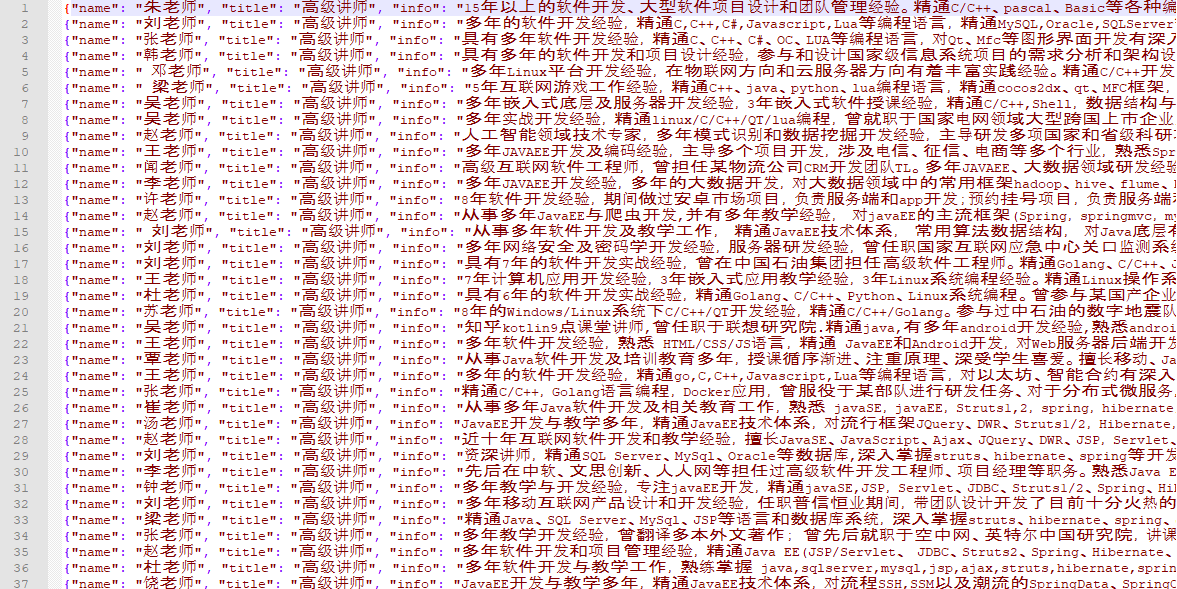

In [5]:
Image(filename="./data/11_6.png",width=500)

## 四.Downloader Middlewares--防止反爬虫

<b>Downloader Middlewares</b>是处于引擎和下载器之间的一层组件,多个下载中中间件可以被同时加载运行.编写下载器中间件十分简单,每个中间件组件都是一个python类,其中定义了`process_request()`方法和`process_response()`方法中的某一个或全部

### 1.process_request(self,request,spider)

用于对请求进行处理,在每个request通过下载中间件时被调用.该方法的参数包括：
1. request：要处理的Request对象
2. spider：该request对应的Spider对象

该方法可能返回None,一个Response,或者一个Request对象,也可能抛出IgnoeRequest异常.针对这4种情况,scrapy有不同的处理方式,具体如下：
1. 如果返回None,scrapy将继续处理该request,执行其他中间件的相应方法,直到合适的下载器处理该函数被调用,该request被执行
2. 如果返回Response对象,scrapy将不会调用任何其他的`process_request()`方法,`process_exception`方法,或相应的下载函数,而是返回该Response.已安装的中间件的process_response()方法则会在每个Response返回时被调用
3. 如果返回Request对象,scrapy将停止调用process_request()方法并重新调度返回的request
4. 如果抛出一个IgnoreRequest异常,则安装的下载中间件的process_exception()方法会被调用

### 2.process_response(self,request,response,spider)

用于对response进行处理,当下载器完成http请求,传递响应给引擎的时候调用.该方法有3个参数：
1. request：是一个Request对象,表示response所对应的request
2. response：是一个Response对象,表示被处理的response
3. spider：是一个spider对象,表示response所对应的spider

该方法有3种执行结果,分别是：返回一个Response对象,返回一个Request对象,或抛出一个IgnoreRequest异常.针对这3种结果,scrapy有不同的处理方式：
1. 如果返回一个Response对象,该Response会被处于链中的其他中间件的process_response()方法处理
2. 处理返回一个Request对象,则中间件链停止,返回的request会被重新调度下载
3. 如果抛出一个IgnoreRequest异常,则调用request的errback(Request.errback)方法

在setttings.py同级目录下创建middlewares.py文件,用于对网络请求进行包装

In [ ]:
import random
import base64
from settings import USER_AGENTS
from settings import PROXIES


# 随机的User-Agent
class RandomUserAgent(object):
    def process_request(self,request,spider):
        useragent=random.choice(USER_AGENTS)
        request.headers.setdefault("User-Agent",useragent)


# 随机的代理IP
class RandomProxy(object):
    def process_request(self,request,spider):
        proxy=random.choice(PROXIES)
        if proxy["user_passwd"] is None:
            #没有代理账户验证的代理使用方式
            request.meta["proxy"]="http://"+proxy["ip_port"]
        else:
            #对账户密码进行base64编码转换
            base64_userpasswd=base64.b64encode(proxy["user_passwd"])
            # 对应到代理服务器的信令格式里
            request.headers["Proxy-Authorization"]="Basic"+base64_userpasswd
            request.meta["proxy"] = "http://" + proxy["ip_port"]

修改settings.py配置USER_AGENTS和PROXIES

In [ ]:
USER_AGENTS=[
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.108 Safari/537.36",
    "Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.108 Safari/537.35"
]

PROXIES=[
    {"ip_port":"221.239.86.26:32228","user_passwd":"pass1"},
    {"ip_port":"119.254.94.114:34422","user_passwd":"pass2"}
]

# 禁用cookies
COOKIES_ENABLED=False

# 设置下载延迟
DOWNLOAD_DELAY=3

DOWNLOADER_MIDDLEWARES={
    'myspider.middlewares.RandomUserAgent':1,
    'myspider.middlewares.ProxyMiddlewate':100
}

## 五.settings

In [ ]:
# 使用scrapy实现的bot名称,也叫项目名称
BOT_NAME = 'myspider'

SPIDER_MODULES = ['myspider.spiders']
NEWSPIDER_MODULE = 'myspider.spiders'


# Crawl responsibly by identifying yourself (and your website) on the user-agent
#USER_AGENT = 'myspider (+http://www.yourdomain.com)'

# Obey robots.txt rules
ROBOTSTXT_OBEY = True

# 设置scrapy downloader并发请求的最大值,默认是16
# Configure maximum concurrent requests performed by Scrapy (default: 16)
#CONCURRENT_REQUESTS = 32

# Configure a delay for requests for the same website (default: 0)
# See https://doc.scrapy.org/en/latest/topics/settings.html#download-delay
# See also autothrottle settings and docs

# 下载延迟.默认值为0
#DOWNLOAD_DELAY = 3
# The download delay setting will honor only one of:
#CONCURRENT_REQUESTS_PER_DOMAIN = 16
#CONCURRENT_REQUESTS_PER_IP = 16

# 禁用Cookies
# Disable cookies (enabled by default)
#COOKIES_ENABLED = False

# Disable Telnet Console (enabled by default)
#TELNETCONSOLE_ENABLED = False


# 设置scrapy HTTP Request使用的默认header
# Override the default request headers:
#DEFAULT_REQUEST_HEADERS = {
#   'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
#   'Accept-Language': 'en',
#}

# 爬虫中间件
# Enable or disable spider middlewares
# See https://doc.scrapy.org/en/latest/topics/spider-middleware.html
#SPIDER_MIDDLEWARES = {
#    'myspider.middlewares.MyspiderSpiderMiddleware': 543,
#}

# 下载中间件
# Enable or disable downloader middlewares
# See https://doc.scrapy.org/en/latest/topics/downloader-middleware.html
#DOWNLOADER_MIDDLEWARES = {
#    'myspider.middlewares.MyspiderDownloaderMiddleware': 543,
#}

# 扩展
# Enable or disable extensions
# See https://doc.scrapy.org/en/latest/topics/extensions.html
#EXTENSIONS = {
#    'scrapy.extensions.telnet.TelnetConsole': None,
#}

# 保存项目中启用的Pipeline及其顺序的字典
# Configure item pipelines
# See https://doc.scrapy.org/en/latest/topics/item-pipeline.html
#ITEM_PIPELINES = {
#    'myspider.pipelines.MyspiderPipeline': 300,
#}

ITEM_PIPELINES = {
    'myspider.pipelines.MyspiderPipeline': 300,
}

# Enable and configure the AutoThrottle extension (disabled by default)
# See https://doc.scrapy.org/en/latest/topics/autothrottle.html
#AUTOTHROTTLE_ENABLED = True
# The initial download delay
#AUTOTHROTTLE_START_DELAY = 5
# The maximum download delay to be set in case of high latencies
#AUTOTHROTTLE_MAX_DELAY = 60
# The average number of requests Scrapy should be sending in parallel to
# each remote server
#AUTOTHROTTLE_TARGET_CONCURRENCY = 1.0
# Enable showing throttling stats for every response received:
#AUTOTHROTTLE_DEBUG = False

## 六.斗鱼APP爬虫

### 1.分析JSON文件内容

### 2.创建项目

修改items.py文件

In [ ]:
class DouyuItem(scrapy.Item):
    # define the fields for your item here like:
    # name = scrapy.Field()
    # 名字
    name=scrapy.Field()
    # 图片链接
    image_link=scrapy.Field()
    # 图片保存地址
    image_path=scrapy.Field()

创建爬虫项目douyupic,修改url和parse()

In [ ]:
import scrapy
import json
from douyu.items import DouyuItem

class DouyupicSpider(scrapy.Spider):
    name = 'douyupic'
    allowed_domains = ['capi.douyucdn.cn']
    offset=0
    url="http://capi.douyucdn.cn/api/v1/getVerticalRoom?limit=20&offset="
    start_urls = [url+str(offset)]


    def parse(self, response):
        data=json.loads(response.text)["data"]
        for each in data:
            item=DouyuItem()
            item["name"]=each["nickname"]
            item["image_link"]=each["vertical_src"]
            yield item
            self.offset+=20

            # 循环发送请求
            yield scrapy.Request(self.url+str(self.offset),callback=self.parse)

修改配置文件

In [ ]:
ITEM_PIPELINES={
    'douyu.pipelines.ImagePipeline':1,
}

IMAGES_STORE="F:\Python\Pytest\spider\Haima\douyu\images"

DEFAULT_REQUEST_HEADERS={

}

添加管道类

In [ ]:
import os
import scrapy
from scrapy.pipelines.images import ImagesPipeline
from scrapy.utils.project import get_project_settings

class ImagesPipeline(ImagesPipeline):
    IMAGES_STORE=get_project_settings().get("IMAGES_STORE")

    def get_media_requests(self,item,info):
        image_url=item["image_link"]
        yield scrapy.Request(image_url)

    def item_completed(self,results,item,info):
        image_path=[x["path"] for ok,x in results if ok]
        os.rename(self.IMAGES_STORE+"/"+image_path[0],self.IMAGES_STORE+"/"+item["name"]+".jpg")
        item["image_path"]=self.IMAGES_STORE+"/"+item["name"]
        return item

执行文件,新建main.py

In [ ]:
from scrapy import cmdline

cmdline.execute("scrapy crawl douyupic".split())